In [2]:
"""
Follows https://www.tensorflow.org/tutorials/text/text_classification_rnn
"""
import pickle as pkl
import numpy as np
import random
import re

import tensorflow_datasets as tfds
import tensorflow as tf

%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime
datetime.now()
EXP_NUM = 17

In [4]:
def plot_graphs(history, metric):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(metric, color=color)
    ax1.plot(history.history[metric], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel("val_" + metric, color=color)  # we already handled the x-label with ax1
    ax2.plot(history.history["val_" + metric], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend([metric, "val_" + metric])

In [5]:
def split_data_into_input_and_output(data):
    """Take given data of format from scraper [link] and return the inputs and outputs seperated.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    data_in, data_out = list(zip(*[((x["synopsis"]), x["gross"]) for x in data]))
    return np.array(data_in), np.array(data_out)

In [6]:
def add_signal(data):
    """
    If the given data has no signal we cant fit a NN to it. As such, here we append how much the film grossed
    into the synopsis of each title.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    for row in data:
        row["synopsis"] = row["synopsis"] + f' The film grossed ${row["gross"]}'

In [7]:
def clean_copy(data, min_length = 10):
    cleaned_data = np.fromiter((x for x in data if len(x["synopsis"].split()) > min_length), dtype=data.dtype)
    print(f"Crushed {len(data)} to {len(cleaned_data)} after removing sub {min_length} word synopses")
    return cleaned_data

In [ ]:
raw_data = pkl.load(open("complete10000_films_and_synopsis.pickle", "rb"))
plt.figure()
word_stats = [(len(x["synopsis"]),len(x["synopsis"].split())) for x in raw_data]
plt.hist([a for a,_ in word_stats], label="characters", bins=100)
plt.figure()
plt.hist([a for _,a in word_stats], label="words", bins=100)
plt.figure()
plt.scatter([a for a,_ in word_stats],[a for _,a in word_stats])

In [9]:
real_data = clean_copy(raw_data)
np.random.shuffle(real_data[500:])
data = real_data

Crushed 10000 to 9742 after removing sub 10 word synopses


In [29]:
# Fraction of overall data
training_fraction = 0.85

train_end = int(len(data) * training_fraction)
train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])

train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))


# How much it loads into memory for sampling
BUFFER_SIZE = 10000
# Batch for gradient averaging
BATCH_SIZE = 64
# prefetch parrallelising loading + execution (not huge so not necessary)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

In [53]:
sample, label = next(iter(train_dataset.take(1)))

In [31]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams=1
)


In [32]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [33]:
encoded_sample = encoder(sample).numpy()[:3]
print(encoded_sample)

[[   7 2169    2    1  377   10   11 4382  317   24  131    2   42   17
   188 9284    6  209    3 1149  989 1662 5928   16   65    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  10 1528  241 1328  791   37    1   34  575 5847    5   12   99   55
  2566  399  174  166   27  826   12 7702    4 2509   31   40    6 3984
    72  251   79  682    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   2   60    5   53  222   16 9826 2741   37    6  101    2  284    6
   400 1077  431  336   21 6856 1351    4  459   17   87 1869    3 2028
     5  304    5    3 2683    0    0    0    0    0    0    0    0    0
     0    0    0    0]]


In [34]:
vocab = np.array(encoder.get_vocabulary())

for n in range(3):
  print("Original: ", sample[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_sample[n]]))
  print()

Original:  b'In 1968, a Czech doctor with an active sex life meets a woman who wants monogamy, and then the Soviet invasion further disrupts their lives.'
Round-trip:  in 1968 a [UNK] doctor with an active sex life meets a woman who wants monogamy and then the soviet invasion further disrupts their lives                     

Original:  b"With 15 year reunion coming up, Kathy has sexual fantasies of her high school sweetheart. She's married, so she sends her BFF to check him out and report back. Things get complicated."
Round-trip:  with 15 year reunion coming up [UNK] has sexual fantasies of her high school sweetheart shes married so she sends her bff to check him out and report back things get complicated              

Original:  b'A group of friends race their high-powered cars up and down a dangerous and deadly mountain road known as Mulholland Drive to see who can claim the title of "King of the Hill."'
Round-trip:  a group of friends race their highpowered cars up and down a dan

In [35]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.1),
)

In [36]:
history = model.fit(
    train_dataset, epochs=100, validation_data=test_dataset, validation_steps=len(test_data_in) // BATCH_SIZE
)

Epoch 1/100
130/130 [==============================] - 23s 180ms/step - loss: 3950100749484032.0000 - val_loss: 754554417184768.0000
Epoch 2/100
130/130 [==============================] - 20s 151ms/step - loss: 3626749304766464.0000 - val_loss: 756270457946112.0000
Epoch 3/100
130/130 [==============================] - 19s 144ms/step - loss: 3523846720192512.0000 - val_loss: 850923685412864.0000
Epoch 4/100
130/130 [==============================] - 19s 146ms/step - loss: 3435465420046336.0000 - val_loss: 925630346559488.0000
Epoch 5/100
130/130 [==============================] - 19s 149ms/step - loss: 3373284762583040.0000 - val_loss: 916999811104768.0000
Epoch 6/100
130/130 [==============================] - 19s 147ms/step - loss: 3299036052324352.0000 - val_loss: 980079794454528.0000
Epoch 7/100
130/130 [==============================] - 19s 145ms/step - loss: 3298792044494848.0000 - val_loss: 1052780169003008.0000
Epoch 8/100
130/130 [==============================] - 19s 146ms/ste

In [37]:
res = model.evaluate(test_dataset)

23/23 [==============================] - 1s 45ms/step - loss: 2351133817307136.0000


In [38]:
sample_text = "As a new threat to the galaxy rises, Rey, a desert scavenger, and Finn, an ex-stormtrooper, must join Han Solo and Chewbacca to search for the one hope of restoring peace."
pred1 = model.predict(np.array([sample_text]))
print(int(pred1[0]))

689549696


In [39]:
non_existant_film = "Este is a friend of mine we meet up every tuesday night for dinner and a glass of wine. She thinks he did it but just cant prove it"
pred2 = model.predict(np.array([non_existant_film]))
print(int(pred2[0]))

12689536


In [10]:
def confusion_plot(lab, pred, name, new_plot=False):
    """
    lab = label
    pred = prediction
    """
    if new_plot:
        plt.figure()
    plt.scatter(lab, lab, label='truth', s=2, color='black')
    plt.scatter(lab, pred, label=name, s=2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.xlabel('Truth')
    plt.ylabel('Prediction')



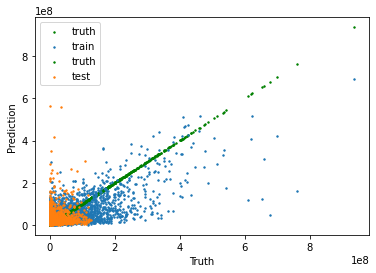

<Figure size 432x288 with 0 Axes>

In [48]:
test_predictions = model.predict(test_data_in)
train_predictions = model.predict(train_data_in)
confusion_plot(train_data_out, train_predictions, 'train')
confusion_plot(test_data_out, test_predictions, 'test')
plt.show()
plt.savefig("exp_{EXP_NUM}.pdf", dpi=300)

Crushed 10000 to 9965 after removing sub 0 word synopses
Crushed 10000 to 9742 after removing sub 10 word synopses
Crushed 10000 to 4899 after removing sub 25 word synopses
Crushed 10000 to 517 after removing sub 50 word synopses


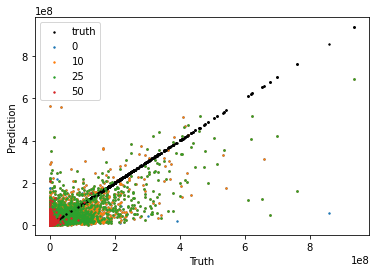

In [60]:
for min_words in [0, 10, 25, 50]:
    data_in, data_out = split_data_into_input_and_output(clean_copy(raw_data, min_words))
    predictions = model.predict(data_in)
    confusion_plot(data_out, predictions, f'{min_words}')

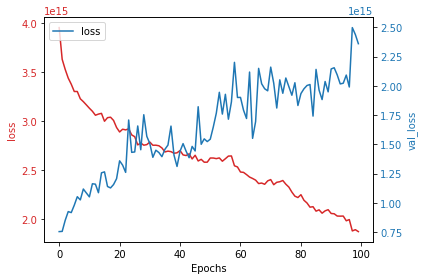

In [41]:
plot_graphs(history,'loss')
plt.savefig("exp_14_2.pdf", dpi=300)

In [ ]:
histories = dict()
models = dict()
experiment_cutoffs = [0,10,25,50]
for min_words in experiment_cutoffs:
    data = clean_copy(raw_data, min_words)
    
    # Fraction of overall data
    training_fraction = 0.85
    train_end = int(len(data) * training_fraction)
    train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
    test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])
    
    # Make dataset objects
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))

    # Shuffle
    # How much it loads into memory for sampling
    BUFFER_SIZE = 10000
    # Batch for gradient averaging
    BATCH_SIZE = 64
    # prefetch parrallelising loading + execution (not huge so not necessary)
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)
    
    # Specify encoding of words
    SUBSET_VOCAB_SIZE = 10000
    encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=SUBSET_VOCAB_SIZE, ngrams=1
    )
    encoder.adapt(train_dataset.map(lambda text, label: text))
    
    # Specify overall architecture
    models[min_words] = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
    )
    models[min_words].compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(0.1),
    )

    # Train
    histories[min_words] = models[min_words].fit(
    train_dataset, epochs=100, validation_data=test_dataset, validation_steps=len(test_data_in) // BATCH_SIZE
    )
    
    # Look at performance
    pred = models[min_words].predict(train_data_in)
    confusion_plot(train_data_out, pred, f'{min_words}')

Crushed 10000 to 9965 after removing sub 0 word synopses
Epoch 1/100
133/133 [==============================] - 29s 219ms/step - loss: 4062345424797696.0000 - val_loss: 1024748192530432.0000
Epoch 2/100
133/133 [==============================] - 25s 192ms/step - loss: 3576971975983104.0000 - val_loss: 764023142350848.0000
Epoch 3/100
133/133 [==============================] - 25s 187ms/step - loss: 3559085584678912.0000 - val_loss: 1381948140290048.0000
Epoch 4/100
133/133 [==============================] - 25s 189ms/step - loss: 3499661222477824.0000 - val_loss: 1409637257576448.0000
Epoch 5/100
133/133 [==============================] - 25s 185ms/step - loss: 3416871701315584.0000 - val_loss: 1164391806402560.0000
Epoch 6/100
133/133 [==============================] - 25s 189ms/step - loss: 3403949486899200.0000 - val_loss: 1056816297410560.0000
Epoch 7/100
133/133 [==============================] - 25s 185ms/step - loss: 3381298097815552.0000 - val_loss: 1165037796327424.0000
Epoch 

In [ ]:
for a in experiment_cutoffs:
    plot_graphs(histories[a],'loss')